In [2]:
from torch_geometric.utils import from_scipy_sparse_matrix
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import scipy.sparse as sp
import numpy as np
import json
from pathlib import Path

In [3]:
path = Path('data_2024')
adj = sp.load_npz(path/'adj.npz')
feat  = np.load(path/'features.npy')
labels = np.load(path/'labels.npy')
splits = json.load(open(path/'splits.json'))
idx_train, idx_test = splits['idx_train'], splits['idx_test']

In [18]:
splits['idx_test']

[2119,
 2206,
 2165,
 1994,
 520,
 521,
 2103,
 1838,
 1840,
 116,
 134,
 2477,
 1522,
 821,
 1393,
 1983,
 2136,
 2478,
 1182,
 1617,
 899,
 1898,
 1592,
 903,
 815,
 1395,
 871,
 1596,
 1188,
 513,
 791,
 1296,
 1608,
 1149,
 1568,
 1625,
 1101,
 829,
 1595,
 1912,
 1856,
 308,
 603,
 1122,
 566,
 2175,
 2066,
 1556,
 339,
 1264,
 531,
 2266,
 3,
 191,
 423,
 2054,
 1098,
 338,
 2215,
 2184,
 302,
 982,
 725,
 362,
 1931,
 2178,
 745,
 1248,
 376,
 171,
 646,
 1569,
 1778,
 1974,
 321,
 156,
 2265,
 1814,
 1050,
 868,
 846,
 1969,
 2382,
 1508,
 636,
 428,
 2164,
 1044,
 1378,
 2259,
 1265,
 809,
 2387,
 1056,
 268,
 1459,
 1509,
 1158,
 1107,
 1024,
 755,
 293,
 2218,
 194,
 770,
 661,
 757,
 1450,
 1328,
 1151,
 986,
 1256,
 325,
 827,
 1300,
 1890,
 607,
 76,
 292,
 2237,
 236,
 1474,
 203,
 1065,
 2317,
 724,
 2308,
 2236,
 100,
 1423,
 1824,
 140,
 1641,
 148,
 1672,
 1540,
 240,
 2145,
 364,
 1291,
 921,
 637,
 1085,
 1484,
 139,
 1587,
 758,
 974,
 1257,
 1476,
 43,
 878,
 226

In [4]:
print("Adjacency matrix shape:", adj.shape)
print("Features shape:", feat.shape)
print("Labels shape:", labels.shape)
print("Number of training instances:", len(idx_train))
print("Number of test instances:", len(idx_test))

Adjacency matrix shape: (2480, 2480)
Features shape: (2480, 1390)
Labels shape: (496,)
Number of training instances: 496
Number of test instances: 1984


In [5]:
edge_index = from_scipy_sparse_matrix(adj)

In [6]:
edge_index[0].shape

torch.Size([2, 10100])

In [7]:
num_rows_to_keep = labels.shape[0]
feat = feat[:num_rows_to_keep]
train_mask = torch.zeros(labels.shape[0], dtype=torch.bool)
train_mask[:496] = 1

In [8]:
test_mask = np.isin(range(len(labels)), idx_train, invert=True)

test_mask = torch.tensor(test_mask)

# Apply the test mask to the test labels and features
test_labels_filtered = labels[test_mask]
test_feat_filtered = feat[test_mask]

# Use the filtered test labels and features to create a Data object
data_test = Data(x=test_feat_filtered, edge_index=edge_index, y=test_labels_filtered)

In [9]:
data = Data(x=torch.tensor(feat, dtype=torch.float),
            edge_index=edge_index[0],
            y=torch.tensor(labels, dtype=torch.long),
           train_mask = torch.tensor(idx_train, dtype=torch.long),
           test_mask = torch.tensor(idx_test, dtype=torch.long))

In [10]:
data

Data(x=[496, 1390], edge_index=[2, 10100], y=[496], train_mask=[496], test_mask=[1984])

In [11]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class CustomGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomGCNConv, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Filter out invalid edge indices
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))
        edge_index = filter_edge_index(edge_index, num_nodes=x.size(0))

        # Normalize node features
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Apply linear transformation
        x = self.lin(x)

        # Propagate messages
        return self.propagate(edge_index, x=x, norm=norm)

    def message(self, x_j, norm):
        return norm.view(-1, 1) * x_j

    def update(self, aggr_out):
        return aggr_out

def filter_edge_index(edge_index, num_nodes):
    mask = (edge_index[0] < num_nodes) & (edge_index[1] < num_nodes)
    edge_index = edge_index[:, mask]
    return edge_index

In [12]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden, num_classes):
        super().__init__()
        self.conv1 = CustomGCNConv(num_node_features, num_hidden)
        self.conv2 = CustomGCNConv(num_hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN(num_node_features=data.x.shape[1], 
            num_hidden=16,
            num_classes=(data.y.max()+1).item()
           ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()

GCN(
  (conv1): CustomGCNConv()
  (conv2): CustomGCNConv()
)

In [16]:
data_test

Data(x=[405, 1390], edge_index=[2], y=[405])

In [15]:
model.eval()
pred = model(data_test).argmax(dim=1)
correct = (pred == data_test.y).sum()
acc = int(correct) / int(data_test)
print(f'Accuracy: {acc:.4f}')

TypeError: 'int' object is not callable

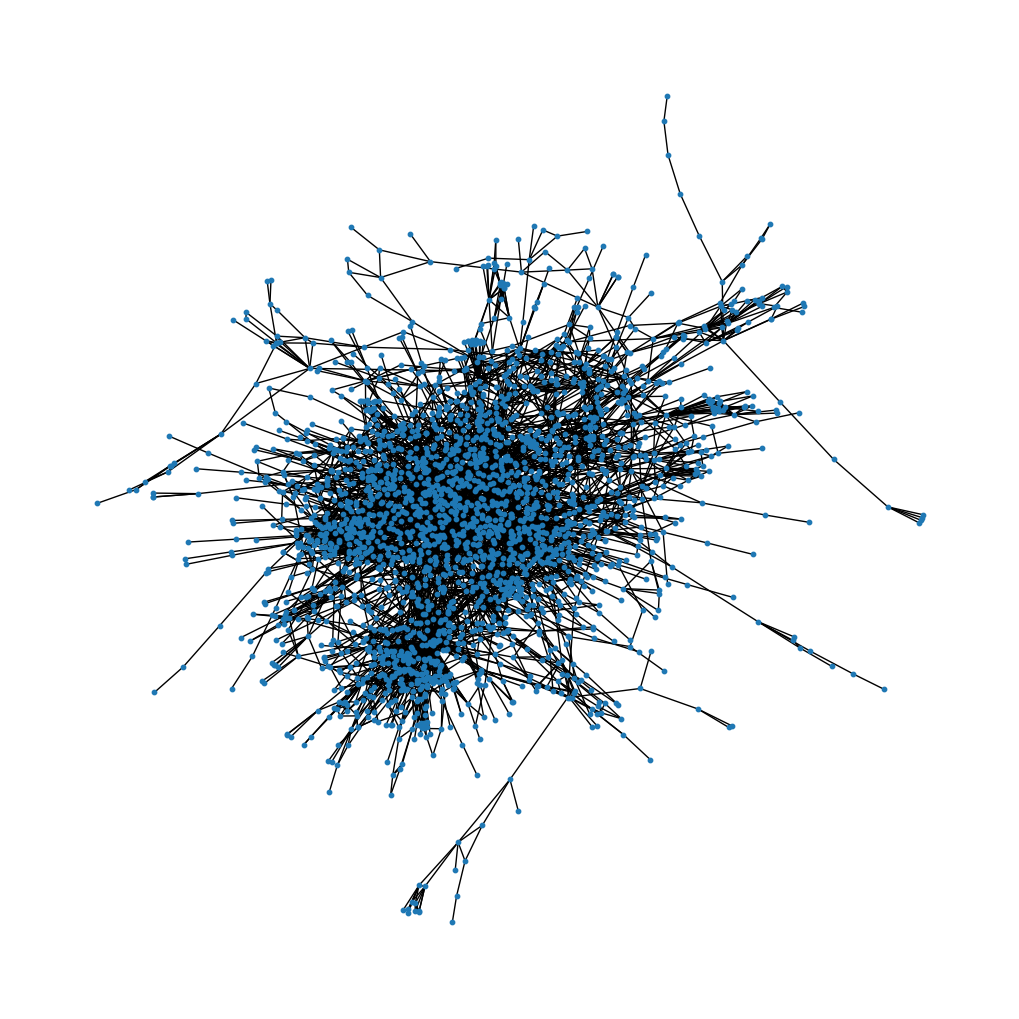

In [27]:
import networkx as nx
import matplotlib.pyplot as plt
G = nx.Graph()
rows, cols = adj.nonzero()
edges = np.column_stack((rows, cols))
sorted_edges = np.lexsort((edges[:, 0], edges[:, 1]))
sorted_edges = edges[sorted_edges]
for i, j in sorted_edges:
    G.add_edge(i, j)

# Draw the graph
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=False, node_size=10)
plt.show()